In [219]:
from datetime import datetime, timedelta

import geopandas as gpd
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt

In [220]:
def munge_time(df, time_column):
    days_of_week = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df["year"] = pd.DatetimeIndex(df[time_column]).year
    df["month"] = pd.DatetimeIndex(df[time_column]).month
    df["hour"] = pd.DatetimeIndex(df[time_column]).hour

    df["year_month"] = df.year.astype(str) + df.month.map(
        lambda x: f"-{x:02}"
    )

    # we want our nominal day of week to end at 3 AM:
    # Sunday morning at 1 AM is pretty much Saturday night for our purposes.
    df[f"shifted_{time_column}_dow"] = pd.DatetimeIndex(df[time_column]).map(
        lambda x: x - timedelta(hours=3)
    )
    dow_type = CategoricalDtype(categories=days_of_week, ordered=True)
    df["day_of_week"] = pd.DatetimeIndex(
        df[f"shifted_{time_column}_dow"]
    ).day_name()
    df["day_of_week"] = df["day_of_week"].astype(dow_type)


In [221]:
epd = pd.read_csv(
    "epd-traffic-violence.csv",
    parse_dates=["call_time", "dispatch_time"],
    date_format="%m/%d/%Y %I:%M:%S %p",
    dtype={"event_number": str, "case": str},
)

In [223]:
munge_time(epd, 'call_time')
epd[
    epd.location.str.contains(r"\b[67]TH", regex=True)
].location.unique().tofile("epd-locations.csv", sep="\n")

# Edit the EPD locations
* Copy `epd-locations.csv` to `epd-locations-edited.csv`
* Edit `epd-locations.csv` to include only locations in the livability project range.
* Proceed

In [224]:
epd_places = pd.read_csv('epd-locations-edited.csv')
epd_6_7 = epd[epd.location.isin(epd_places.place)]

In [225]:
ems = pd.read_csv('ems-traffic-violence.csv', parse_dates=['dispatch_datetime'])

In [226]:
munge_time(ems, 'dispatch_datetime')
ems[
    (ems.location.str.contains(" [67]TH AVE", regex=True))
    & (ems.city == "EUG")
].location.unique().tofile("ems-locations.csv", sep="\n")


# Edit the EMS locations
* Copy `ems-locations.csv` to `ems-locations-edited.csv`
* Edit `ems-locations.csv` to include only locations in the livability project range.
* Proceed

In [227]:
ems_places = pd.read_csv('ems-locations-edited.csv')
ems_6_7 = ems[ems.location.isin(ems_places.place)]

In [250]:
def full_vs_6th_7th_by_timeframe(
    full, some, timeframe, label, incident_type=None
):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    if incident_type is None:
        groups = timeframe
    else:
        groups = [timeframe, incident_type]

    full.groupby(groups, observed=False).size().plot.line(
        color="green", ax=ax1
    )
    some.groupby(groups, observed=False).size().plot.line(
        color="brown", ax=ax2
    )

    ax1.set_ylabel(f"All {label}", color="green")
    ax2.set_ylabel(f"6th and 7th {label}", color="brown")
    ax1.set_ylim(ymin=0)
    ax2.set_ylim(ymin=0)


for agency in ["epd", "ems"]:
    for tf in ["year", "year_month", "month", "day_of_week", "hour"]:
        full_vs_6th_7th_by_timeframe(
            eval(agency),
            eval(f"{agency}_6_7"),
            tf,
            f"{agency.upper()} Traffic Incidents",
        )
for crash_type in ems.description.unique():
    crash_all = ems[ems.description == crash_type]
    crash_6_7 = ems_6_7[ems_6_7.description == crash_type]
    for tf in ["year", "year_month", "month", "day_of_week", "hour"]:
        full_vs_6th_7th_by_timeframe(
            crash_all,
            crash_6_7,
            tf,
            f"EMS {crash_type}"
        )

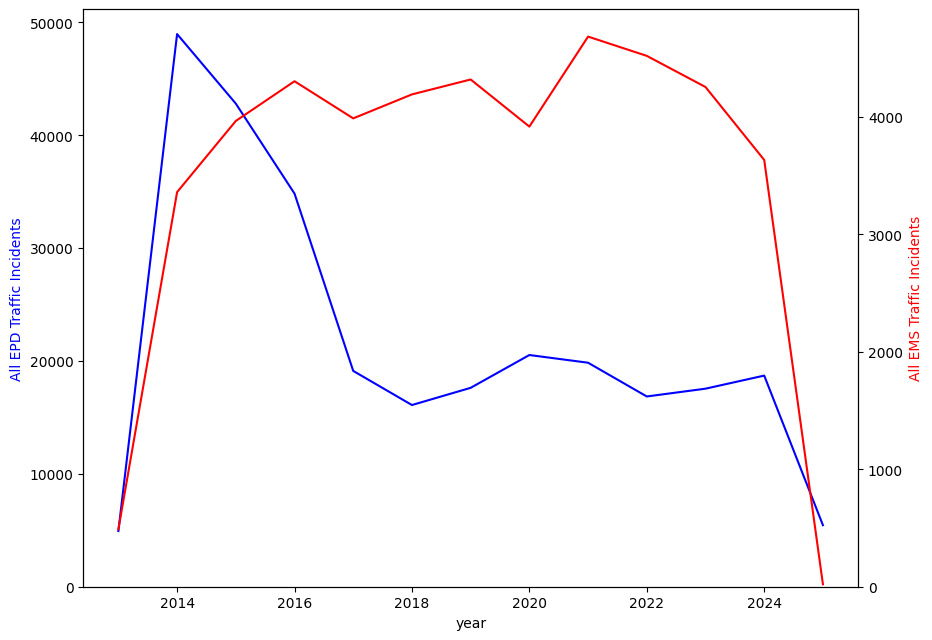

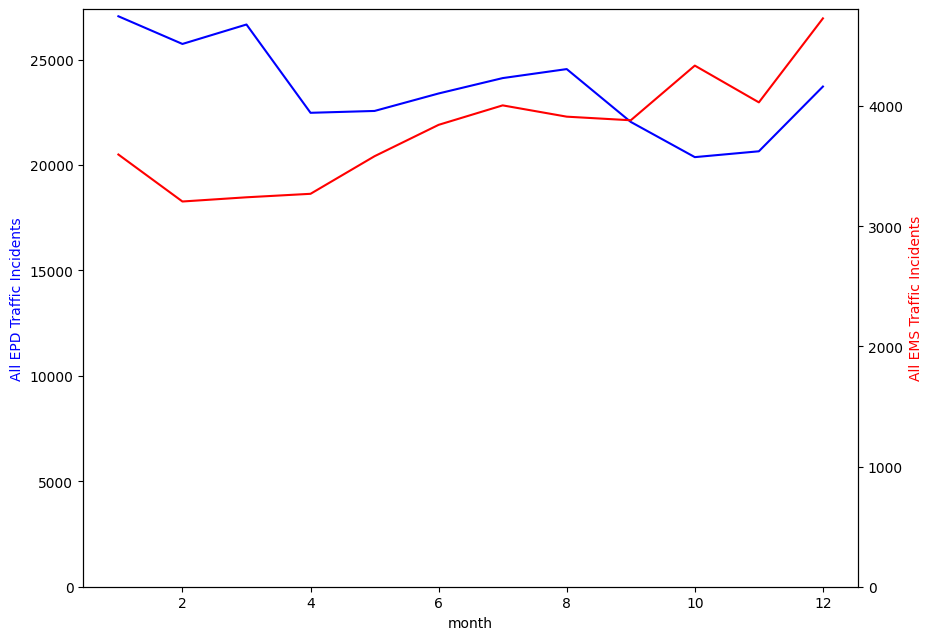

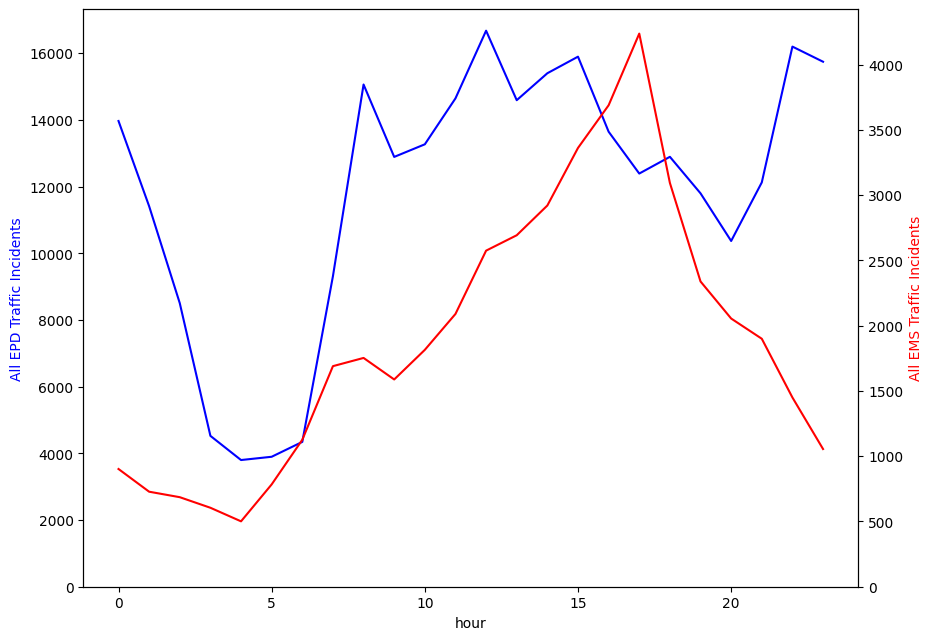

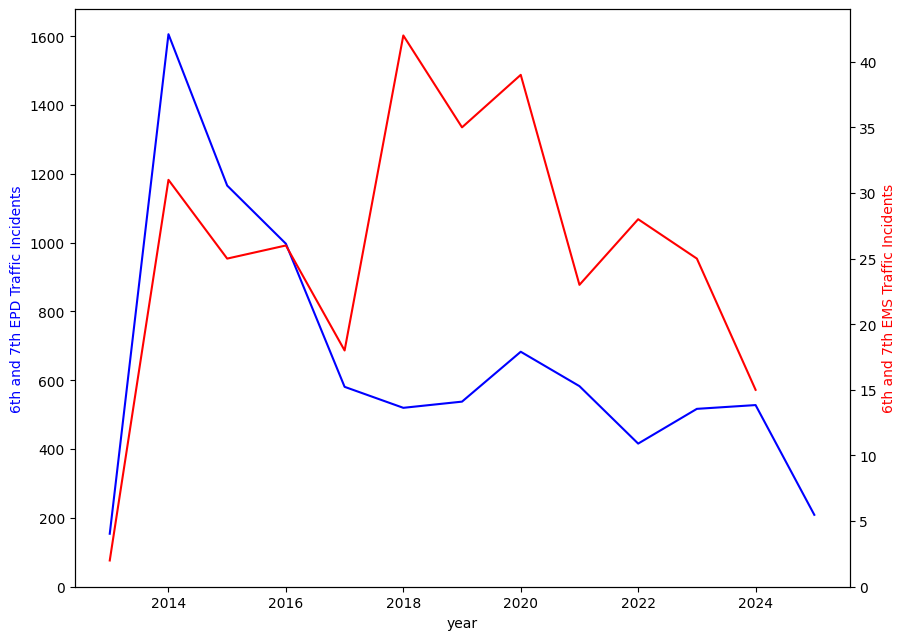

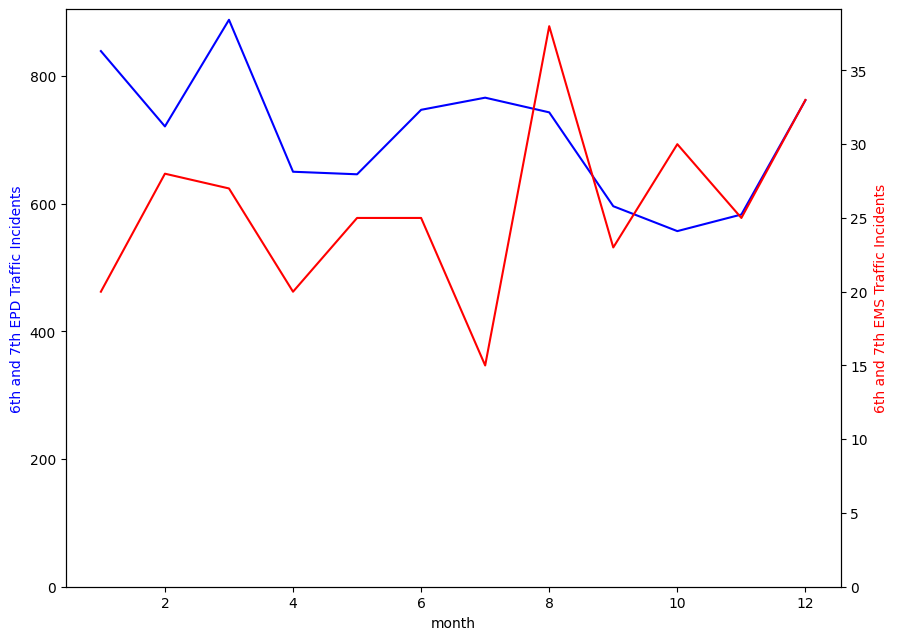

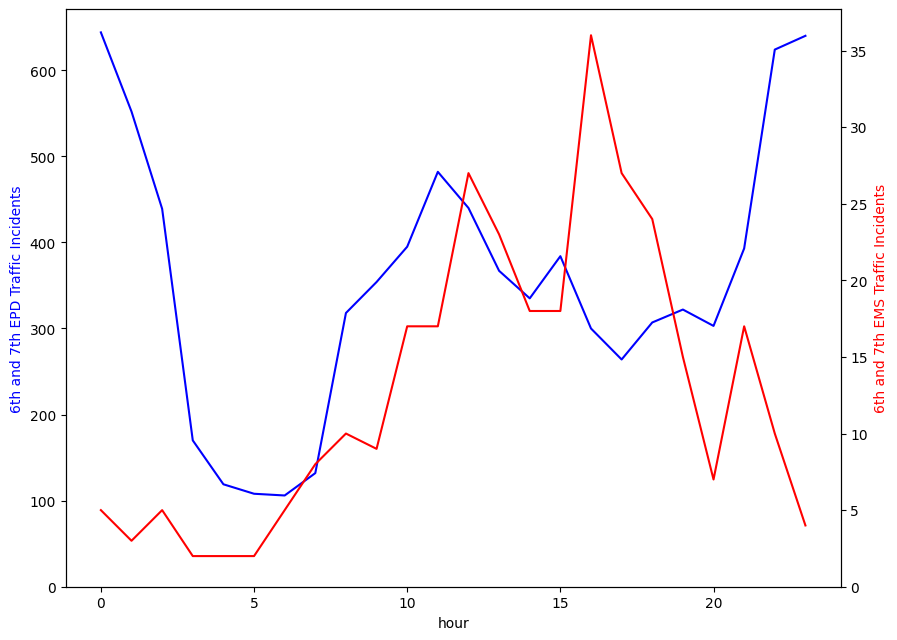

In [235]:
def epd_vs_ems_by_timeframe(epd, ems, timeframe, label, incident_type=None):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    epd.groupby(timeframe).size().plot.line(color='blue', ax=ax1)
    ems.groupby(timeframe).size().plot.line(color='red', ax=ax2)

    ax1.set_ylabel(f'{label} EPD Traffic Incidents', color='blue')
    ax2.set_ylabel(f'{label} EMS Traffic Incidents', color='red')
    ax1.set_ylim(ymin=0)
    ax2.set_ylim(ymin=0)


epd_vs_ems_by_timeframe(epd, ems, 'year', 'All')
epd_vs_ems_by_timeframe(epd, ems, 'month', 'All')
epd_vs_ems_by_timeframe(epd, ems, 'hour', 'All')
epd_vs_ems_by_timeframe(epd_6_7, ems_6_7, 'year', '6th and 7th')
epd_vs_ems_by_timeframe(epd_6_7, ems_6_7, 'month', '6th and 7th')
epd_vs_ems_by_timeframe(epd_6_7, ems_6_7, 'hour', '6th and 7th')
